success,size,topic,acks,compression,inflight,batch,linger,time,rate,latency

In [2]:
import csv

metrics = []
with open('metrics/metrics-corr-1-raw.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        metrics.append(row)

In [3]:
def to_float(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s

for metric in metrics:
    for key in metric:
        metric[key] = to_float(metric[key])

In [4]:
def filter_unsuccessful(metric):
    if metric['success'] == 0:
        metric['rate'] = 0
        metric['latency'] = -1
        metric['success'] = 1
    return dict(metric)
        
filtered = [filter_unsuccessful(m) for m in metrics]

In [5]:
from itertools import groupby
from operator import itemgetter

grouper = itemgetter('size', 'acks', 'inflight')

sorted_a = sorted(filtered, key=grouper)
grouped = groupby(sorted_a, key=grouper)
sorted_by_rate = {k:sorted(v, key=itemgetter('rate'), reverse=True)[:10] for k, v in grouped}

In [6]:
for conf, metrics in sorted_by_rate.items():
    with open(f"metrics/groups/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(['batch', 'linger', 'rate'])
        for metric in metrics:
            w.writerow([metric['batch'], metric['linger'], metric['rate']])

In [7]:
from collections import Counter

counters = {}
for g, metrics in sorted_by_rate.items():
    batch_counts = Counter(m['batch'] for m in metrics)
    linger_counts = Counter(m['linger'] for m in metrics)
    counters[g] = {'batch': batch_counts.most_common(1)[0][0], 'linger': linger_counts.most_common(1)[0][0]}

In [8]:
data_batches={}
data_lingers={}
for conf, metric in counters.items():
    if not (conf[1],conf[2]) in data_batches:
        data_batches[(conf[1],conf[2])] = {}
    data_batches[(conf[1],conf[2])][conf[0]] = metric['batch']
    
    if not (conf[1],conf[2]) in data_lingers:
        data_lingers[(conf[1],conf[2])] = {}
    data_lingers[(conf[1],conf[2])][conf[0]] = metric['linger']

In [9]:
for conf, lingers in data_lingers.items():
    with open(f"metrics/lingers/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(["size"," linger"])
        for size, linger in lingers.items():
            w.writerow([size, linger])
            
for conf, batches in data_batches.items():
    with open(f"metrics/batches/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(["size", "batch"])
        for size, batch in batches.items():
            w.writerow([size, batch])

In [10]:
lingers_b = {}
for conf in data_lingers:
    with open(f"metrics/lingers-b/{conf}", 'r') as f:
        r = csv.DictReader(f)
        lingers_b[conf] = []
        for row in r:
            lingers_b[conf].append(dict(row))

            
batches_b = {}
for conf in data_batches:
    with open(f"metrics/batches-b/{conf}", 'r') as f:
        r = csv.DictReader(f)
        batches_b[conf] = []
        for row in r:
            batches_b[conf].append(dict(row))

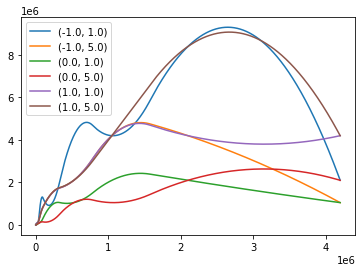

In [11]:
import numpy as np
from matplotlib import pyplot
from scipy.interpolate import interp1d

xs = np.linspace(128, 4194304, 100000)

batch_funcs = {}

for conf, metrics in batches_b.items():
    batch_f = interp1d(np.array([to_float(x['size']) for x in metrics]), np.array([to_float(x['batch']) for x in metrics]), kind='quadratic', fill_value=(512, 8388608), bounds_error=False)
    pyplot.plot(xs, batch_f(xs), label=str(conf))
    batch_funcs[conf] = batch_f
pyplot.legend()
pyplot.show()

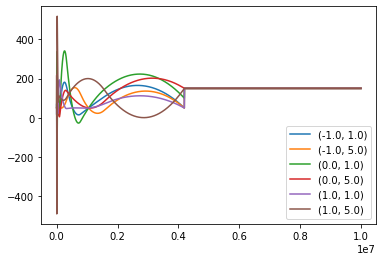

In [12]:
import numpy as np
from matplotlib import pyplot

xs = np.linspace(128, 10000000, 500000)

linger_funcs = {}

for conf, metrics in lingers_b.items():
    linger_f = interp1d(np.array([to_float(x['size']) for x in metrics]), np.array([to_float(x['linger']) for x in metrics]), kind='quadratic', fill_value=(20, 150), bounds_error=False)
    pyplot.plot(xs, linger_f(xs), label=str(conf))
    linger_funcs[conf] = linger_f
pyplot.legend()
#pyplot.axis([0, 40000, -100, 300])
pyplot.show()

In [13]:
batches_fk = {}
batches_fv = {}
lingers_fk = {}
lingers_fv = {}

for conf in lingers_b:
    with open(f"metrics/lingers-f/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(["size", "linger"])
        lingers_fk[conf] = []
        lingers_fv[conf] = []
        for i in range(1, 4150000, 600000):
            w.writerow([i, linger_funcs[conf](i)])
            lingers_fk[conf].append(i)
            lingers_fv[conf].append(linger_funcs[conf](i))
                
for conf in batches_b:
    with open(f"metrics/batches-f/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(["size", "batch"])
        batches_fk[conf] = []
        batches_fv[conf] = []
        for i in range(1, 4150000, 600000):
            w.writerow([i, batch_funcs[conf](i)])
            batches_fk[conf].append(i)
            batches_fv[conf].append(batch_funcs[conf](i))

ValueError: Image size of 3000000x2000000 pixels is too large. It must be less than 2^16 in each direction.

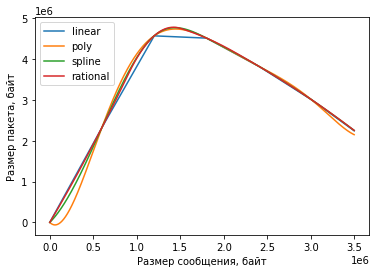

In [15]:
from scipy.interpolate import interp1d, lagrange, BarycentricInterpolator

inter_funcs_batch = {}
keys = np.array(batches_fk[(-1., 5.)])
values = np.array(batches_fv[(-1., 5.)])
inter_funcs_batch['linear'] = interp1d(keys, values, kind='linear')
inter_funcs_batch['poly'] = lagrange(keys, values)
inter_funcs_batch['spline'] = interp1d(keys, values, kind='cubic')
inter_funcs_batch['rational'] = interp1d(keys, values, kind='quadratic')

xs = np.linspace(128, 3500001, 500000)

for name, func in inter_funcs_batch.items():
    pyplot.plot(xs, func(xs), label=name)
pyplot.legend()
pyplot.xlabel('Размер сообщения, байт')
pyplot.ylabel('Размер пакета, байт')
pyplot.savefig('images/funcs.png', dpi=500000)
pyplot.show()

In [ ]:
np.save("lingers", linger_funcs)
np.save("batches", batch_funcs)

In [ ]:
funcs = np.load("lingers.npy", allow_pickle=True)
funcs.item()[(-1., 1.)](4242113)